### A pipeline for a binary image classification

It uses a 

In [120]:
import os
import glob
import time
import copy
import datetime

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

from PIL import Image
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader

In [121]:
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.0.1.post2
Torchvision Version:  0.2.2


## Set global variables

In [122]:
USE_KAGGLE_KERNEL = True
BATCH_SIZE = 256
NUM_CLASSES = 2

# For first runs use only subset of the data
subset_size = 0.01

# How to split training-val-test sets
# test set and validation size are divided equally from the rest
TRAINING_SIZE=0.9

# If the training should be resumed from a saved checkpoint
RESUME_TRAINING = True
RESUME_TRAINING_PATH = '../input/histopathology-resnet50-clr/histopathology_resnet50_subset100_2019-03-29-14-17-57.pth'

# Set model type
MODEL_NAME = "resnet50"
if MODEL_NAME == "inception":
    MODEL_PRETRAINED = models.inception_v3(pretrained=True)
    MODEL_FOR_PREDS = models.inception_v3()
elif MODEL_NAME == "resnet50":
    MODEL_PRETRAINED = models.resnet50(pretrained=True)
    MODEL_FOR_PREDS = models.resnet50()
elif MODEL_NAME == "resnet18":
    MODEL_PRETRAINED = models.resnet18(pretrained=True)
    MODEL_FOR_PREDS = models.resnet18()

# Resize image size
if MODEL_NAME == 'inception':
    INPUT_SIZE = 299
else:
    INPUT_SIZE = 96
    
TIMESTAMP = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
CHECKPOINT_PATH = "histopathology_{model_name}_subset{subset_size}_{ts}.pth".format(model_name=model_name,
                                                                                    subset_size=int(subset_size * 100),
                                                                                    ts=TIMESTAMP)
print("Will save checkpoint in " + checkpoint_path)

# how many subprocesses to use for data loading. 0 means that
# the data will be loaded in the main process
NUM_WORKERS=0

Will save checkpoint in histopathology_resnet50_subset1_2019-04-06-14-14-03.pth


## Data preparation

In [123]:
class DataSplit():
    
    def __init__(self, X, y, full_train_labels_df=None):
        self.X = X
        self.y = y
        self.X_train_path, self.y_train = [], []
        self.X_val_paths, self.y_val  = [], []
        self.X_test_paths, self.y_test = [], []
        self.train_labels_df = full_train_labels_df

    def split(self, training_size=0.8):
        random_state = np.random.RandomState(seed=42)

        # 1. Divide the full set into training and the rest
        sss_train_and_rest = StratifiedShuffleSplit(n_splits=1, test_size=1-training_size, random_state=random_state)
        for train_index, rest_index in sss_train_and_rest.split(self.X, self.y):
            X_train, X_rest = X[train_index], X[rest_index]
            self.y_train, y_rest = y[train_index], y[rest_index]

        # 2. Divide the rest equally into validation and (local) test set
        sss_test_and_val = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=random_state)
        for val_index, test_index in sss_test_and_val.split(X_rest, y_rest):
            X_val, X_test = X_rest[val_index], X_rest[test_index]
            self.y_val, self.y_test = y_rest[val_index], y_rest[test_index]

        # Get lists of paths to inputs
        self.X_train_paths = np.array([TRAIN_PATH + i + ".tif" for i in X_train])
        self.X_val_paths = np.array([TRAIN_PATH + i + ".tif" for i in X_val])
        self.X_test_paths = np.array([TRAIN_PATH + i + ".tif" for i in X_test])

        self.assert_no_intersections()

    def assert_no_intersections(self):
        X_train_set = set(X_train)
        X_val_set = set(X_val)
        X_test_set = set(X_test)
        assert(X_train_set.intersection(X_val_set) == set())
        assert(X_train_set.intersection(X_test_set) == set())
        assert(X_val_set.intersection(X_test_set) == set())
    
    def get_class_distr(self, subset):
        return np.sum(subset)/len(subset)

    def print_splits(self, num_classes=2):
        """
        Check that the class distribution is roughly the same across subsets
        """
        print("We'll use {}% ({}) of the full sample size ({})".format(int(subset_size * 100),
                                                                       int(len(self.train_labels_df) * subset_size),
                                                                       int(len(self.train_labels_df))))
        if num_classes == 2:
            print()
            print("Set    | Size   | Class distribution")
            print("------------------------------------")
            print("Full   | {:6} | {:.2f}".format(len(self.train_labels_df.label), get_class_distr(self.train_labels_df.label)))
            print("Subset | {:6} | {:.2f}".format(len(self.y), get_class_distr(self.y)))
            print("Train  | {:6} | {:.2f}".format(len(self.y_train), get_class_distr(self.y_train)))
            print("Val    | {:6} | {:.2f}".format(len(self.y_val), get_class_distr(self.y_val)))
            print("Test   | {:6} | {:.2f}".format(len(self.y_test), get_class_distr(self.y_test)))

Divide the data into three stratified sets: training, validation, test.

In [124]:
if USE_KAGGLE_KERNEL:
    TRAIN_LABELS = '../input/histopathologic-cancer-detection/train_labels.csv'
    TRAIN_PATH = '../input/histopathologic-cancer-detection/train/'
else:
    TRAIN_LABELS = 'train_labels.csv'
    TRAIN_PATH = 'train/'

train_labels_df = pd.read_csv(TRAIN_LABELS)
train_labels_subset_df = train_labels_df[:int(len(train_labels_df)*subset_size)]

X = train_labels_subset_df.id.values
y = train_labels_subset_df.label.values

split = DataSplit(X, y, full_train_labels_df=train_labels_df)
split.split(training_size = TRAINING_SIZE)
split.print_splits(num_classes=NUM_CLASSES)

We'll use 1% (2200) of the full sample size (220025)

Set    | Size   | Class distribution
------------------------------------
Full   | 220025 | 0.41
Subset |   2200 | 0.40
Train  |   1980 | 0.40
Val    |    110 | 0.40
Test   |    110 | 0.39



### Initialize input data transforms

In [125]:
# The pre-trained torch models expect input images normalized in the same way
# as they were originally trained
normalization_mean_std = [[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]]

data_transforms = {
    'train': transforms.Compose([
            transforms.RandomGrayscale(),
            transforms.RandomRotation(30),
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((90,90)),
                ]),
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((270,270)),
                ]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
                ]),
            transforms.RandomChoice([
                transforms.ColorJitter(brightness=0.5),
                transforms.ColorJitter(contrast=0.5), 
                transforms.ColorJitter(saturation=0.5),
                transforms.ColorJitter(hue=0.5),
                transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
            ]),
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
    'val': transforms.Compose([
            transforms.Resize(INPUT_SIZE),
            transforms.ToTensor(),
            transforms.Normalize(*normalization_mean_std)
        ]),
}

### Setup Datasets and Dataloaders

In [126]:
class CancerDataset(Dataset):

    def __init__(self, num_classes, files_path, labels=None, transform=None):
        self.files = files_path
        self.transform = transform
        self.one_hot_labels = torch.eye(num_classes)[labels] if labels is not None else None

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        path = self.files[idx]
        sample_id = os.path.basename(path)[:-len(".tif")]
        image = Image.open(path)

        if self.transform:
            image = self.transform(image)

        sample = {'id': sample_id,
                  'image': image}

        if self.one_hot_labels is not None:
            sample['label'] = self.one_hot_labels[idx]

        return sample

## Training

In [127]:
transformed_datasets = {
    "train": CancerDataset(num_classes = NUM_CLASSES,
                           files_path = split.X_train_paths,
                           labels = split.y_train,
                           transform = data_transforms["train"]),
    "val": CancerDataset(num_classes = NUM_CLASSES,
                         files_path = split.X_val_paths,
                         labels = split.y_val,
                         transform = data_transforms["val"])
}

dataloaders = {
    "train": DataLoader(transformed_datasets["train"],
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS),
    "val": DataLoader(transformed_datasets["val"],
                             batch_size=BATCH_SIZE,
                             shuffle=True,
                             num_workers=NUM_WORKERS)}

### Visualize examples

In [128]:
# Quick test of data loading and input sizes
for i_batch, sample_batched in enumerate(dataloaders['train']):
    print(i_batch, 
          sample_batched['image'].size(),
          sample_batched['label'].size())
    if i_batch == 5:
        break

0 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
1 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
2 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
3 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
4 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])
5 torch.Size([256, 3, 96, 96]) torch.Size([256, 2])


### Add plotting functions

In [129]:
from sklearn.metrics import roc_curve, auc

class Plot():
    
    @staticmethod
    def plot_results(losses, accuracies):
        f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 6))
        ax1.plot(np.squeeze(losses['train']), 'r', label='train')
        ax1.plot(np.squeeze(losses['val']), 'g', label='val')
        ax1.set_ylabel('loss', fontsize=14)
        ax1.set_xlabel('epochs', fontsize=14)
        ax1.set_ylim(0, 1.3)
        ax1.legend()

        ax2.plot(np.squeeze(accuracies['train']), 'r', label='train')
        ax2.plot(np.squeeze(accuracies['val']), 'g', label='val')
        ax2.set_ylabel('accuracy', fontsize=14)
        ax2.set_xlabel('epochs', fontsize=14)
        ax2.set_ylim(0, 1.3)
        ax2.legend()

        plt.show()
        plt.savefig(model_name + '_loss_and_acc.png')

    @staticmethod
    def get_auroc(y_val, pred_val, plot=False):
        fpr, tpr, _ = roc_curve(y_val, pred_val)
        auroc = auc(fpr, tpr)

        if plot:
            plt.figure()
            lw = 2
            plt.plot(fpr, tpr, color='darkorange',
                     lw=lw, label='ROC curve (area = %0.4f)' % auroc)
            plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver operating characteristic')
            plt.legend(loc="lower right")
            plt.show()
            plt.savefig(model_name + '_auroc.png')

        return auroc

### Initialize pretrained model

In [132]:
model_ft = MODEL_PRETRAINED

# reinitialize model.fc (final fully connected layer) to be a Linear layer
# with the same number of input features and <NUM_CLASSES> output features
num_ftrs = model_ft.fc.in_features

# in addtion to the output layer, inception models produce auxiliary layer
if model_name == 'inception':
    model_ft.AuxLogits = models.inception.InceptionAux(768, num_classes)

model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Freeze the first n modules
frozen = True
if frozen == True:
    child_counter = 0
    for child in model_ft.children():
        print("Child", child_counter)
        if child_counter < 6:
            print("was frozen")
            for param in child.parameters():
                param.requires_grad = False
        else:
            print("NOT frozen")           
        print("-----")
        child_counter += 1
        
print()

print("Params to learn:")
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        print("\t", name)
        
model_ft = nn.DataParallel(model_ft)
model_ft.cuda()

Child 0
was frozen
-----
Child 1
was frozen
-----
Child 2
was frozen
-----
Child 3
was frozen
-----
Child 4
was frozen
-----
Child 5
was frozen
-----
Child 6
NOT frozen
-----
Child 7
NOT frozen
-----
Child 8
NOT frozen
-----
Child 9
NOT frozen
-----

Params to learn:
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.conv3.weight
	 layer3.0.bn3.weight
	 layer3.0.bn3.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer3.1.bn2.bias
	 layer3.1.conv3.weight
	 layer3.1.bn3.weight
	 layer3.1.bn3.bias
	 layer3.2.conv1.weight
	 layer3.2.bn1.weight
	 layer3.2.bn1.bias
	 layer3.2.conv2.weight
	 layer3.2.bn2.weight
	 layer3.2.bn2.bias
	 layer3.2.conv3.weight
	 layer3.2.bn3.weight
	 layer3.2.bn3.bias
	 layer3.3.conv1.weight
	 layer3.3.bn1.weight
	

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): C

### Criterion & Optimizer

In [133]:
from torch.optim.optimizer import Optimizer
import math

# Class to be merged into PyTorch (as of March 2019)
# https://github.com/pytorch/pytorch/blob/b526e3ceaa0a83312ac22ac9daf06028967c1da2/torch/optim/lr_scheduler.py
class CyclicLR(lr_scheduler._LRScheduler):
    """Sets the learning rate of each parameter group according to
    cyclical learning rate policy (CLR). The policy cycles the learning
    rate between two boundaries with a constant frequency, as detailed in
    the paper `Cyclical Learning Rates for Training Neural Networks`_.
    The distance between the two boundaries can be scaled on a per-iteration
    or per-cycle basis.
    Cyclical learning rate policy changes the learning rate after every batch.
    `step` should be called after a batch has been used for training.
    This class has three built-in policies, as put forth in the paper:
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    This implementation was adapted from the github repo: `bckenstler/CLR`_
    Args:
        optimizer (Optimizer): Wrapped optimizer.
        base_lr (float or list): Initial learning rate which is the
            lower boundary in the cycle for each parameter group.
        max_lr (float or list): Upper learning rate boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size_up (int): Number of training iterations in the
            increasing half of a cycle. Default: 2000
        step_size_down (int): Number of training iterations in the
            decreasing half of a cycle. If step_size_down is None,
            it is set to step_size_up. Default: None
        mode (str): One of {triangular, triangular2, exp_range}.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
            Default: 'triangular'
        gamma (float): Constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
            Default: 1.0
        scale_fn (function): Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            If specified, then 'mode' is ignored.
            Default: None
        scale_mode (str): {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle).
            Default: 'cycle'
        cycle_momentum (bool): If ``True``, momentum is cycled inversely
            to learning rate between 'base_momentum' and 'max_momentum'.
            Default: True
        base_momentum (float or list): Initial momentum which is the
            lower boundary in the cycle for each parameter group.
            Default: 0.8
        max_momentum (float or list): Upper momentum boundaries in the cycle
            for each parameter group. Functionally,
            it defines the cycle amplitude (max_momentum - base_momentum).
            The momentum at any cycle is the difference of max_momentum
            and some scaling of the amplitude; therefore
            base_momentum may not actually be reached depending on
            scaling function. Default: 0.9
        last_epoch (int): The index of the last batch. This parameter is used when
            resuming a training job. Since `step()` should be invoked after each
            batch instead of after each epoch, this number represents the total
            number of *batches* computed, not the total number of epochs computed.
            When last_epoch=-1, the schedule is started from the beginning.
            Default: -1
    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = torch.optim.CyclicLR(optimizer)
        >>> data_loader = torch.utils.data.DataLoader(...)
        >>> for epoch in range(10):
        >>>     for batch in data_loader:
        >>>         train_batch(...)
        >>>         scheduler.step()
    .. _Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    .. _bckenstler/CLR: https://github.com/bckenstler/CLR
    """

    def __init__(self,
                 optimizer,
                 base_lr,
                 max_lr,
                 step_size_up=2000,
                 step_size_down=None,
                 mode='triangular',
                 gamma=1.,
                 scale_fn=None,
                 scale_mode='cycle',
                 cycle_momentum=True,
                 base_momentum=0.8,
                 max_momentum=0.9,
                 last_epoch=-1):

        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer

        base_lrs = self._format_param('base_lr', optimizer, base_lr)
        if last_epoch == -1:
            for lr, group in zip(base_lrs, optimizer.param_groups):
                group['lr'] = lr

        self.max_lrs = self._format_param('max_lr', optimizer, max_lr)

        step_size_up = float(step_size_up)
        step_size_down = float(step_size_down) if step_size_down is not None else step_size_up
        self.total_size = step_size_up + step_size_down
        self.step_ratio = step_size_up / self.total_size

        if mode not in ['triangular', 'triangular2', 'exp_range'] \
                and scale_fn is None:
            raise ValueError('mode is invalid and scale_fn is None')

        self.mode = mode
        self.gamma = gamma

        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = self._triangular_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = self._triangular2_scale_fn
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = self._exp_range_scale_fn
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode

        self.cycle_momentum = cycle_momentum
        if cycle_momentum:
            if 'momentum' not in optimizer.defaults:
                raise ValueError('optimizer must support momentum with `cycle_momentum` option enabled')

            base_momentums = self._format_param('base_momentum', optimizer, base_momentum)
            if last_epoch == -1:
                for momentum, group in zip(base_momentums, optimizer.param_groups):
                    group['momentum'] = momentum
        self.base_momentums = list(map(lambda group: group['momentum'], optimizer.param_groups))
        self.max_momentums = self._format_param('max_momentum', optimizer, max_momentum)

        super(CyclicLR, self).__init__(optimizer, last_epoch)

    def _format_param(self, name, optimizer, param):
        """Return correctly formatted lr/momentum for each param group."""
        if isinstance(param, (list, tuple)):
            if len(param) != len(optimizer.param_groups):
                raise ValueError("expected {} values for {}, got {}".format(
                    len(optimizer.param_groups), name, len(param)))
            return param
        else:
            return [param] * len(optimizer.param_groups)

    def _triangular_scale_fn(self, x):
        return 1.

    def _triangular2_scale_fn(self, x):
        return 1 / (2. ** (x - 1))

    def _exp_range_scale_fn(self, x):
        return self.gamma**(x)

    def get_lr(self):
        """Calculates the learning rate at batch index. This function treats
        `self.last_epoch` as the last batch index.
        If `self.cycle_momentum` is ``True``, this function has a side effect of
        updating the optimizer's momentum.
        """
        cycle = math.floor(1 + self.last_epoch / self.total_size)
        x = 1. + self.last_epoch / self.total_size - cycle
        if x <= self.step_ratio:
            scale_factor = x / self.step_ratio
        else:
            scale_factor = (x - 1) / (self.step_ratio - 1)

        lrs = []
        for base_lr, max_lr in zip(self.base_lrs, self.max_lrs):
            base_height = (max_lr - base_lr) * scale_factor
            if self.scale_mode == 'cycle':
                lr = base_lr + base_height * self.scale_fn(cycle)
            else:
                lr = base_lr + base_height * self.scale_fn(self.last_epoch)
            lrs.append(lr)

        if self.cycle_momentum:
            momentums = []
            for base_momentum, max_momentum in zip(self.base_momentums, self.max_momentums):
                base_height = (max_momentum - base_momentum) * scale_factor
                if self.scale_mode == 'cycle':
                    momentum = max_momentum - base_height * self.scale_fn(cycle)
                else:
                    momentum = max_momentum - base_height * self.scale_fn(self.last_epoch)
                momentums.append(momentum)
            for param_group, momentum in zip(self.optimizer.param_groups, momentums):
                param_group['momentum'] = momentum

        return lrs

In [134]:
criterion = nn.BCEWithLogitsLoss()

# optimizer_ft = optim.Adam(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.0001)
optimizer_ft = optim.SGD(list(filter(lambda p: p.requires_grad, model_ft.parameters())), lr=0.1, momentum=0.9)

scheduler = None
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer_ft, mode='min', patience=4)
scheduler = CyclicLR(optimizer_ft, base_lr=0.1, max_lr=1, step_size_up=1000)

In [135]:
if RESUME_TRAINING:
    print("Training will be resumed.")
    checkpoint = torch.load(RESUME_TRAINING_PATH)
    model_ft.load_state_dict(checkpoint['model_state_dict'])
    optimizer_ft.load_state_dict(checkpoint['optimizer_state_dict'])

Training will be resumed.


## Training

In [ ]:
# Early stopping implementation adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.best_model = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
#         torch.save(model.state_dict(), 'checkpoint.pt')
        self.best_model = model
        self.val_loss_min = val_loss

In [ ]:
def to_gpu(tensors):
    return tensors.pin_memory().cuda(non_blocking=True)

class TrainTracker(object):

    def __init__(self, checkpoint_path, model_state, dataloaders, num_epochs):
        self.since = time.time()
        self.best_model_wts = copy.deepcopy(model_state)
        self.dataloaders = dataloaders
        self.log = self.setup_log_file(checkpoint_path)
        self.num_epochs = num_epochs

        # best validation scores and their epochs
        self.best_acc = {'value': 0.0, 'epoch': 0}
        self.best_auroc = {'value': 0.0, 'epoch': 0}
        
        # lists of metrics, one per epoch
        self.losses = {'train': [], 'val': []}
        self.accuracies = {'train': [], 'val': []}
        
        # updated after every batch
        self.running_loss = 0.0
        self.running_corrects = 0
        
        # used only for the val phase (needed for AUROC)
        # aurocs, one per epoch
        self.val_aurocs = []
        # labels and predictions from a given epoch
        self.val_running_labels = []
        self.val_running_preds = []
        # labels and predictions that gave the best AUROC
        self.val_best_labels = []
        self.val_best_preds = []

    def setup_log_file(self, checkpoint_path):
        log_name = checkpoint_path + '_' + TIMESTAMP + '.log'
        print("Log file: " + log_name)
        return open(log_name, 'a')

    def save_checkpoint(self, path, model, optimizer, epoch):
        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'train_loss': self.losses['train'][-1],
                    'train_auroc': self.accuracies['train'][-1],
                    'val_loss': self.losses['val'][-1],
                    'val_auroc': self.accuracies['val'][-1]
                   }, path)
        return path
        
    def init_epoch_metrics(self, phase):
        self.running_loss = 0.0
        self.running_corrects = 0
        self.val_running_labels = []
        self.val_running_preds = []

    def update_epoch_metrics(self, phase, epoch, model, optimizer):
        epoch_loss = self.running_loss / len(self.dataloaders[phase].dataset)
        epoch_acc = self.running_corrects.double() / len(self.dataloaders[phase].dataset)
        self.losses[phase].append(epoch_loss)
        self.accuracies[phase].append(epoch_acc)

        if phase == 'val':
            epoch_auroc = Plot.get_auroc(self.val_running_labels, self.val_running_preds, plot=False)
            self.val_aurocs.append(epoch_auroc)
            if epoch_auroc > self.best_auroc['value']:
                self.best_auroc = {'value': epoch_auroc, 'epoch': epoch}
                self.val_best_labels = self.val_running_labels
                self.val_best_preds = self.val_running_preds
                
                self.best_model_wts = copy.deepcopy(model.state_dict())
                self.save_checkpoint(checkpoint_path, model, optimizer, epoch)

            if epoch_acc > self.best_acc['value']:
                self.best_acc = {'value': epoch_acc, 'epoch': epoch}

    def update_running_metrics(self, phase, outputs, loss, inputs, labels, preds):
        """
        Metrics update after every batch
        """
        flat_labels = to_gpu(torch.tensor([i[1] for i in labels.data], dtype=torch.long))
        self.running_loss += loss.item() * inputs.size(0)
        self.running_corrects += torch.sum(preds == flat_labels)

        # gather the "probabilities" (scores) of the tumor present and the true labels
        if phase == 'val':
            y_probs = torch.sigmoid(outputs).detach().cpu().numpy()[:, 1]
            self.val_running_labels.extend(labels.detach().cpu().numpy()[:, 1])
            self.val_running_preds.extend(y_probs)

    def print_epoch_summary(self, epoch, epoch_starttime):
        if self.losses and self.accuracies and self.val_aurocs:
            template = 'Epoch {}/{} | Train: loss {:.4f} acc {:.4f} | Val: loss {:.4f} acc {:.4f} auroc: {:.4f} | Time: {:.2f}s'
            message = template.format(
                  epoch, self.num_epochs,
                  self.losses['train'][-1], self.accuracies['train'][-1],
                  self.losses['val'][-1], self.accuracies['val'][-1],
                  self.val_aurocs[-1],
                  time.time() - epoch_starttime)
            print(message)
            self.log.write(message + "\n")

    def print_final_summary(self):
        time_elapsed = time.time() - self.since
        mesg1 = 'Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)
        mesg2 = 'Best val acc: {:4f}, epoch: {}'.format(self.best_acc['value'], self.best_acc['epoch'])
        mesg3 = 'Best val auroc: {:4f}, epoch: {}'.format(self.best_auroc['value'], self.best_auroc['epoch'])

        print(mesg1)
        print(mesg2)
        print(mesg3)

        Plot.plot_results(self.losses, self.accuracies)
        auc = Plot.get_auroc(self.val_best_labels, self.val_best_preds, plot=True)
        mesg4 = 'AUROC: {:4f}'.format(auc)
        print(mesg4)

        self.log.write(mesg1 + "\n")
        self.log.write(mesg2 + "\n")
        self.log.write(mesg3 + "\n")
        self.log.write(mesg4 + "\n")
        self.log.close()
    
    def get_best_model_weights(self):
        return self.best_model_wts

def train_model(model, criterion, optimizer, dataloaders, checkpoint_path, scheduler=None,
                num_epochs=25, apply_early_stopping=False, is_inception=False):
    """
    Trains for the specified number of epochs and after each epoch runs a full validation step.
    It keeps track of the best performing model (in terms of validation accuracy), and at the
    end of training returns the best performing model. After each epoch, the training and
    validation accuracies are printed.
    Adapted from: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
    """
    tracker = TrainTracker(checkpoint_path, model.state_dict(), dataloaders, num_epochs)

    if apply_early_stopping:
        early_stopping = EarlyStopping(verbose=False)

    print("Training started..")
    for epoch in range(1, num_epochs + 1):
        epoch_starttime = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            # zero values before starting each phase
            tracker.init_epoch_metrics(phase)

            # Iterate over batches of data. Batch size is defined in DataLoader.
            for batch_num, sample in enumerate(dataloaders[phase]):
                inputs = to_gpu(sample['image'])
                labels = to_gpu(sample['label'])

                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                    
                    # get the position of the max value of each row (argmax)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        # CyclicLR step() should be called after each batch
                        if scheduler and scheduler.__class__.__name__ == 'CyclicLR':
                            scheduler.step(batch_num)

                tracker.update_running_metrics(phase, outputs, loss, inputs, labels, preds)

            tracker.update_epoch_metrics(phase, epoch, model, optimizer)

            if phase == 'val':
                # ReduceLROnPlateau step() should be called after the validation phase
                if scheduler and scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    scheduler.step(epoch_loss)

        tracker.print_epoch_summary(epoch, epoch_starttime)

        if apply_early_stopping:
            if losses:
                early_stopping(tracker.losses['val'][-1], tracker.get_best_model_weights())
            if early_stopping.early_stop:
                break

    tracker.print_final_summary()
    
    # load best model weights
    model.load_state_dict(tracker.get_best_model_weights())
    return model

Log file: histopathology_resnet50_subset1_2019-04-06-14-51-44.pth_2019-04-06-14-51-44.log
Training started..
Epoch 1/4 | Train: loss 0.1830 acc 0.9247 | Val: loss 0.1789 acc 0.9455 auroc: 0.9766 | Time: 5.94s
Epoch 2/4 | Train: loss 0.1662 acc 0.9414 | Val: loss 0.1762 acc 0.9455 auroc: 0.9762 | Time: 5.68s
Epoch 3/4 | Train: loss 0.1608 acc 0.9434 | Val: loss 0.1763 acc 0.9455 auroc: 0.9756 | Time: 5.77s
Epoch 4/4 | Train: loss 0.1511 acc 0.9389 | Val: loss 0.1772 acc 0.9545 auroc: 0.9759 | Time: 5.61s
Training complete in 0m 23s
Best val acc: 0.954545, epoch: 4
Best val auroc: 0.976584, epoch: 1


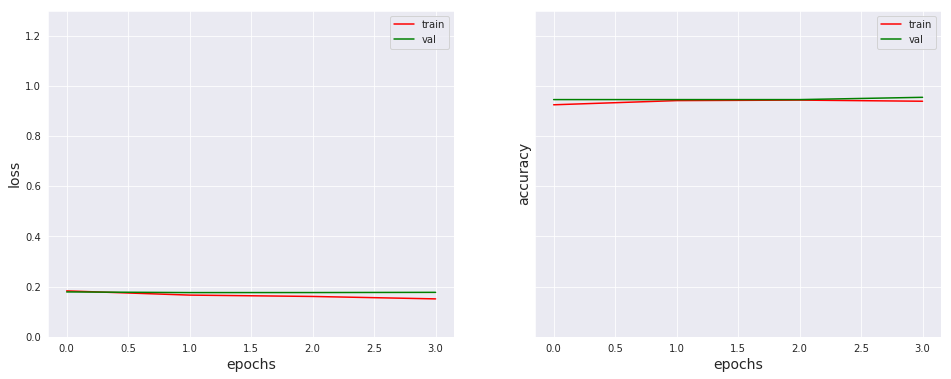

<Figure size 432x288 with 0 Axes>

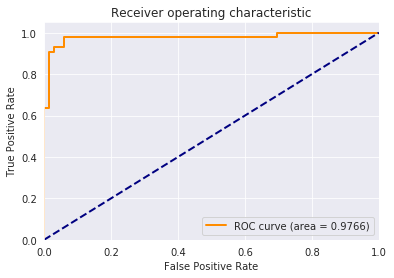

AUROC: 0.976584


<Figure size 432x288 with 0 Axes>

In [136]:
model_ft_trained = train_model(model_ft, criterion, optimizer_ft, dataloaders, CHECKPOINT_PATH, scheduler=scheduler,
                               num_epochs=4, apply_early_stopping=False, is_inception=model_name=='inception')

## Inference

In [137]:
ttas = []

ttas.append(
    data_transforms['val'])

ttas.append(transforms.Compose([
            transforms.RandomChoice([
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((90,90)),
                ]),
                transforms.Compose([
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation((270,270)),
                ]),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip()
                ]),
            data_transforms['val']]))

ttas.append(transforms.Compose([
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    data_transforms['val']]))

ttas.append(transforms.Compose([
    transforms.RandomChoice([
        transforms.RandomGrayscale(p=0.6),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip()
    ]),
    data_transforms['val']]))

ttas.append(transforms.Compose([
    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5), 
        transforms.ColorJitter(saturation=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1), 
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.3), 
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5), 
    ]),
    transforms.RandomChoice([
        transforms.RandomRotation((0,0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((90,90)),
        ]),
        transforms.Compose([
            transforms.RandomHorizontalFlip(p=1),
            transforms.RandomRotation((270,270)),
        ]),
    ]),
    data_transforms['val']]))

def predict(test_loader, model_pred):
    model_pred.eval()
    model_pred.cuda()
    ids_all = []
    predictions = []
    for _, batch in enumerate(test_loader):
        X = batch["image"]        
        ids_all.extend(batch["id"])
        with torch.set_grad_enabled(False):
            y_pred = model_pred(X)
            # the second element of the one-hot vector will contain
            # the probability the image contains a tumor
            predictions.extend(torch.sigmoid(y_pred).detach().cpu().numpy()[:, 1])
    return ids_all, predictions

def get_tta_predictions(ttas, test_paths, verbose=False):
    tta_ids = None
    tta_preds = []
    for index, tta in enumerate(ttas):
        if verbose:
            print("Running {} predictions with tta {}".format(len(test_paths), index))
        # Load the test data
        test_dataset = CancerDataset(num_classes = num_classes,
                                     files_path = test_paths,
                                     transform = tta)

        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=NUM_WORKERS
        )

        # Load a new model and apply the trained weights
        trained_model = MODEL_FOR_PREDS
        features_count = trained_model.fc.in_features
        trained_model.fc = nn.Linear(features_count, num_classes)
        if model_name == 'inception':
            trained_model.AuxLogits = models.inception.InceptionAux(768, num_classes)
        trained_model.cuda()
        trained_model = nn.DataParallel(trained_model)
        trained_model.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])

        ids, predictions = predict(test_loader, trained_model)
        assert(len(ids) == len(predictions))
        tta_ids = ids
        tta_preds.append(predictions)
    if verbose:
        print("Got {} TTA predictions".format(len(tta_preds)))
    
    tta_mean = np.mean(np.array(tta_preds), axis=0)
    
    # tta_mean shape is (len(test_paths),)
    return tta_ids, tta_preds, tta_mean

## Run predictions for kaggle submission

In [138]:
if USE_KAGGLE_KERNEL:
    SUBMISSION_TEMPLATE = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
    TEST_PATH = "../input/histopathologic-cancer-detection/test"
else:
    SUBMISSION_TEMPLATE = pd.read_csv('sample_submission.csv')
    TEST_PATH = "../test"

kaggle_test_file_list = glob.glob(TEST_PATH + "/*.tif")[:10000]

print("Size of kaggle test set (for evaluation on kaggle):", len(kaggle_test_file_list))

# Calculate mean predictions
tta_ids, tta_preds, tta_mean_preds = get_tta_predictions(ttas, kaggle_test_file_list)
submit_predictions = pd.DataFrame({
    "id": tta_ids,
    "label": tta_mean_preds
}).set_index("id")

# Submit the results
to_submit = pd.merge(SUBMISSION_TEMPLATE, submit_predictions, how='left', on='id')
to_submit = to_submit[['id', 'label_y']]
to_submit.columns = ['id', 'label']

# assert(len(to_submit) == len(tta_mean_preds))
to_submit.to_csv(CHECKPOINT_PATH + "_predictions.csv", index=False)

Size of kaggle test set (for evaluation on kaggle): 10000


## Run local test

In [139]:
# code from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[6 1]
 [0 4]]


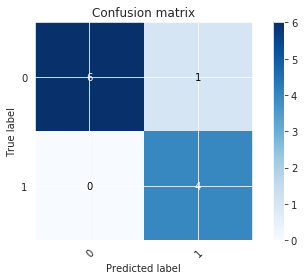

Confusion matrix, without normalization
[[6 1]
 [0 4]]


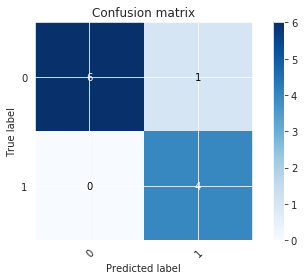

AUROC
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean: 1.0000, std: 0.0000

Accuracy
[0.9091, 0.9091, 1.0, 0.9091, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
Mean: 0.9727, std: 0.0417


In [140]:
split_num = 10
local_test = StratifiedShuffleSplit(n_splits=split_num, test_size=0.1, random_state=random_state)

X_tests = []
y_tests = []

for _, test_index in local_test.split(X_test_paths, y_test):
    X_tests.append(X_test_paths[test_index])
    y_tests.append(y_test[test_index])

tta_preds_means = []
aurocs = []
accuracy_scores = []
i = 0
for X_part, y_part in zip(X_tests, y_tests):
    ids, tta_preds, tta_preds_mean = get_tta_predictions(ttas, X_part, verbose=False)
    tta_preds_means.append(tta_preds_mean)
    auroc_part = Plot.get_auroc(y_part, tta_preds_mean, plot=False)
    aurocs.append(auroc_part)
    binary_preds = (tta_preds_mean > 0.5).astype(int)    
    accuracy_scores.append(accuracy_score(y_part, binary_preds))
    if i < 2:
        plot_confusion_matrix(y_part, binary_preds, classes=[0, 1], normalize=False, title='Confusion matrix')
        plt.show()
        i+=1
    
print("AUROC")
print([round(i, 4) for i in aurocs])
print("Mean: {:.4f}, std: {:.4f}".format(np.mean(aurocs), np.std(aurocs)))

print()
print("Accuracy")
print([round(i, 4) for i in accuracy_scores])
print("Mean: {:.4f}, std: {:.4f}".format(np.mean(accuracy_scores), np.std(accuracy_scores)))